## Recurrent Neural Network from scratch

© Christian Herta, Davide Posillipo

Adapted from http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/recurrentNeuralNetworks.php, for the Sequences class at Data Science Retreat, 2020, Berlin.

Reference reading for the mathematical explanation of RNN: Deep Learning (Goodfellow et al.), section 10.2. 

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

dtype=theano.config.floatX

%matplotlib inline

In [2]:
from reberGrammar import reberGrammar
n_in  = 7 
n_hid = 10
n_out = 7

In [3]:
reber_grammar = reberGrammar()

In [4]:
v = T.matrix(dtype=dtype) 

In [5]:
def rescale_weights(values, factor=1.):
    factor = np.cast[dtype](factor)
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values

def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in range(sizeX):
        vals = np.random.uniform(low=-1., high=1.,  size=(sizeY,))
        #vals_norm = np.sqrt((vals**2).sum())
        #vals = vals / vals_norm
        values[dx,:] = vals
    _,svs,_ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values

In [6]:
def get_parameter(n_in, n_out, n_hid):
    b_h = theano.shared(np.zeros(n_hid, dtype=dtype)) 
    h0 = theano.shared(np.zeros(n_hid, dtype=dtype))
    W_ih = theano.shared(sample_weights(n_in, n_hid))
    W_hh = theano.shared(sample_weights(n_hid, n_hid))
    W_ho = theano.shared(sample_weights(n_hid, n_out))
    b_o = theano.shared(np.zeros(n_out, dtype=dtype)) 
    return W_ih, W_hh, b_h, W_ho, b_o, h0

W_ih, W_hh, b_h, W_ho, b_o, h0 = get_parameter(n_in, n_out, n_hid)   
params = [W_ih, W_hh, b_h, W_ho, b_o, h0]

In [7]:
def logistic_function(x):
    return 1./(1 + T.exp(-x))

# sequences: x_t
# prior results: h_tm1
# non-sequences: W_ih, W_hh, W_ho, b_h
def one_step(x_t, h_tm1, W_ih, W_hh, b_h, W_ho, b_o):
    h_t = T.tanh(theano.dot(x_t, W_ih) + theano.dot(h_tm1, W_hh) + b_h)
    y_t = theano.dot(h_t, W_ho) + b_o 
    y_t = logistic_function(y_t) 
    return [h_t, y_t]

In [8]:
# hidden and outputs of the entire sequence
[h_vals, o_vals], _ = theano.scan(fn=one_step, 
                                  sequences = dict(input=v, taps=[0]), 
                                  outputs_info = [h0, None], # corresponds to return type of fn
                                  non_sequences = [W_ih, W_hh, b_h, W_ho, b_o] )

In [9]:
# target values
target = T.matrix(dtype=dtype)

In [10]:
# learning rate
lr = np.cast[dtype](0.2)
learning_rate = theano.shared(lr)

In [11]:
# Loss function
cost = -T.mean(target * T.log(o_vals) + (1.- target) * T.log(1. - o_vals))

In [12]:
def get_train_functions(cost, v, target):
    gparams = []
    for param in params:
        gparam = T.grad(cost, param)
        gparams.append(gparam)

    updates=[]
    for param, gparam in zip(params, gparams):
        updates.append((param, param - gparam * learning_rate))
    learn_rnn_fn = theano.function(inputs = [v, target],
                                   outputs = cost,
                                   updates = updates)
    return learn_rnn_fn

In [13]:
learn_rnn_fn = get_train_functions(cost, v, target)

In [14]:
learn_rnn_fn

In [15]:
train_data = reber_grammar.get_n_examples(1000)

In [16]:
def train_rnn(train_data, nb_epochs=50):      
  train_errors = np.ndarray(nb_epochs)
  for x in range(nb_epochs):
    error = 0.
    for j in range(len(train_data)):  
        index = np.random.randint(0, len(train_data))
        i, o = train_data[index]
        train_cost = learn_rnn_fn(i, o)
        error += train_cost
    train_errors[x] = error
  return train_errors

nb_epochs=10
train_errors = train_rnn(train_data, nb_epochs)

In [17]:
def plot_learning_curve(train_errors, nb_epochs=nb_epochs):
    plt.plot(np.arange(nb_epochs), train_errors, 'b-')
    plt.xlabel('epochs')
    plt.ylabel('error')

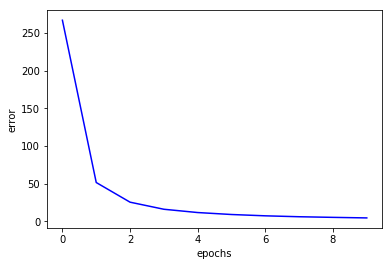

In [18]:
plot_learning_curve(train_errors)

In [19]:
predictions = theano.function(inputs = [v], outputs = o_vals)

In [20]:
o_vals

for{cpu,scan_fn}.1

In [21]:
inp, outp = reber_grammar.get_one_example(10)
pre = predictions(inp)
for p, o in zip(pre, outp):
    print(p) # prediction
    print(o) # target
    print(np.round(p))
    print('\n')

[3.27740784e-03 9.96073181e-01 1.17630747e-03 8.79928712e-04
 9.92164612e-01 9.02037173e-03 6.20220701e-03]
[0. 1. 0. 0. 1. 0. 0.]
[0. 1. 0. 0. 1. 0. 0.]


[3.62494587e-04 9.67162029e-01 4.54697002e-02 4.37049130e-02
 3.26309337e-03 9.69880128e-01 2.85830237e-04]
[0. 1. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 1. 0.]


[2.47969959e-04 9.98503253e-01 5.99326637e-04 5.82817510e-04
 2.03429015e-03 9.98085469e-01 6.53863085e-04]
[0. 1. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 1. 0.]


[1.74773535e-04 9.97103046e-01 3.32324542e-04 3.33013537e-04
 2.84336613e-03 9.99566347e-01 3.78200960e-04]
[0. 1. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 1. 0.]


[1.86864331e-04 9.98592274e-01 1.87457896e-04 1.86564513e-04
 2.17633417e-03 9.99585426e-01 5.86877476e-04]
[0. 1. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 1. 0.]


[6.58624514e-04 3.75272631e-03 2.93191012e-04 1.64959007e-04
 9.93633819e-01 9.97126159e-01 3.16940216e-03]
[0. 0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 1. 0.]


[9.33994995e-04 1.64605295e-03 9.88711135e-01 9.88389132e-01
 6.